<a href="https://colab.research.google.com/github/intimanjunath/Neural-network-using-numpy-keras-pytorch-and-jax/blob/main/5_Tensorflow_various_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

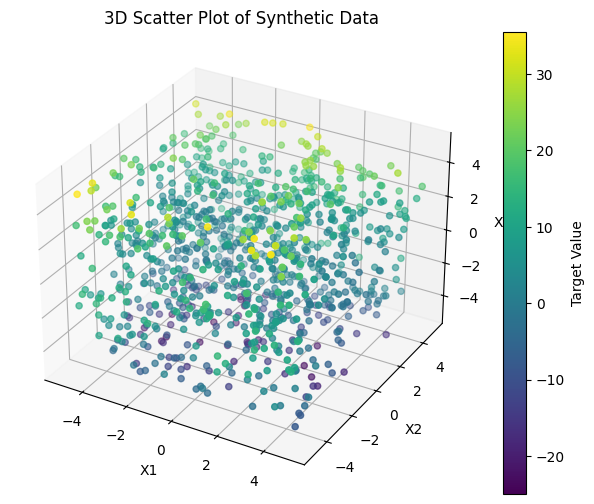

In [1]:
#Synthetic Data Generation and Visualization
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting

def generate_synthetic_data(n_samples=1000):
    # Generate three input features uniformly in [-5, 5]
    x1 = np.random.uniform(-5, 5, n_samples)
    x2 = np.random.uniform(-5, 5, n_samples)
    x3 = np.random.uniform(-5, 5, n_samples)

    # Define a non-linear function and add some noise:
    # Example: 1.5*sin(x1) + 0.6*x2^2 + 0.2*x3^3 + cos(x1*x2) + Gaussian noise
    noise = np.random.normal(0, 0.3, n_samples)
    y = 1.5 * np.sin(x1) + 0.6 * (x2**2) + 0.2 * (x3**3) + np.cos(x1*x2) + noise

    # Stack features together
    X = np.column_stack((x1, x2, x3))
    return X.astype(np.float32), y.astype(np.float32)

# Generate datasets for training, validation, and testing
X_train, y_train = generate_synthetic_data(1000)
X_val, y_val = generate_synthetic_data(200)
X_test, y_test = generate_synthetic_data(200)

# Visualize the generated data in a 3D scatter plot (4th dimension by color)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c=y_train, cmap='viridis')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.colorbar(scatter, label='Target Value')
plt.title("3D Scatter Plot of Synthetic Data")
plt.show()

In [2]:
# Data Preprocessing: Normalization and Train/Test Split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Normalize features and target values
X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train.reshape(-1,1))
X_val_norm = scaler_X.transform(X_val)
y_val_norm = scaler_y.transform(y_val.reshape(-1,1))
X_test_norm = scaler_X.transform(X_test)
y_test_norm = scaler_y.transform(y_test.reshape(-1,1))

#TensorFlow Model Variants

Below are four different implementations:

(a) Low-Level TensorFlow Implementation (Manual)

This version uses tf.Variables and a manual training loop with tf.GradientTape.

In [3]:
import tensorflow as tf

class LowLevelTFModel:
    def __init__(self, learning_rate=0.001):
        # Initialize weights with Glorot Uniform initializer
        initializer = tf.initializers.GlorotUniform()
        self.W1 = tf.Variable(initializer(shape=(3, 32)), trainable=True)
        self.b1 = tf.Variable(tf.zeros([32]), trainable=True)
        self.W2 = tf.Variable(initializer(shape=(32, 16)), trainable=True)
        self.b2 = tf.Variable(tf.zeros([16]), trainable=True)
        self.W3 = tf.Variable(initializer(shape=(16, 1)), trainable=True)
        self.b3 = tf.Variable(tf.zeros([1]), trainable=True)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)

    def forward(self, x, training=True):
        z1 = tf.matmul(x, self.W1) + self.b1
        a1 = tf.nn.relu(z1)
        if training:
            a1 = tf.nn.dropout(a1, rate=0.2)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = tf.nn.relu(z2)
        if training:
            a2 = tf.nn.dropout(a2, rate=0.2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        return z3

    @tf.function
    def train_step(self, x, y):
        with tf.GradientTape() as tape:
            predictions = self.forward(x, training=True)
            loss = tf.reduce_mean(tf.square(y - predictions))
        grads = tape.gradient(loss, [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3])
        self.optimizer.apply_gradients(zip(grads, [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]))
        return loss

In [4]:
#(b) Keras Sequential API Model - This variant builds the network using tf.keras.Sequential.
from tensorflow.keras import layers, models

def create_sequential_model():
    model = models.Sequential([
        layers.Dense(32, activation='relu', input_shape=(3,)),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [6]:
#(c) Functional API Model - This version uses the Functional API to define the model.
def create_functional_model():
    inputs = layers.Input(shape=(3,))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [7]:
#(d) Subclassing Model - We subclass tf.keras.Model to define our network.
class CustomSubclassModel(tf.keras.Model):
    def __init__(self):
        super(CustomSubclassModel, self).__init__()
        self.dense1 = layers.Dense(32, activation='relu')
        self.dropout1 = layers.Dropout(0.2)
        self.dense2 = layers.Dense(16, activation='relu')
        self.dropout2 = layers.Dropout(0.2)
        self.out_layer = layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        if training:
            x = self.dropout1(x, training=True)
        x = self.dense2(x)
        if training:
            x = self.dropout2(x, training=True)
        return self.out_layer(x)

In [8]:
# Training and Evaluation Functions - Below we define functions to train each variant and plot the results.
def train_low_level_model(model, X_train, y_train, X_val, y_val, epochs=100):
    train_losses = []
    X_train_tf = tf.convert_to_tensor(X_train)
    y_train_tf = tf.convert_to_tensor(y_train)
    for epoch in range(epochs):
        loss = model.train_step(X_train_tf, y_train_tf)
        train_losses.append(loss.numpy())
        if epoch % 10 == 0:
            val_pred = model.forward(tf.convert_to_tensor(X_val), training=False)
            val_loss = tf.reduce_mean(tf.square(tf.convert_to_tensor(y_val) - val_pred))
            print(f"Epoch {epoch}, Train Loss: {loss.numpy():.4f}, Val Loss: {val_loss.numpy():.4f}")
    return train_losses

def train_keras_model(model, X_train, y_train, X_val, y_val, epochs=100):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    return history.history['loss'], model

def plot_results(losses, model, X_test, y_test, variant_name):
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 3, 1)
    plt.plot(losses, label='Training Loss')
    plt.title(f'{variant_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Make predictions on test set
    if variant_name == 'Low-Level':
        y_pred = model.forward(tf.convert_to_tensor(X_test), training=False).numpy()
    else:
        y_pred = model.predict(X_test)

    # Inverse transform predictions and actual values
    y_pred_orig = scaler_y.inverse_transform(y_pred)
    y_test_orig = scaler_y.inverse_transform(y_test)

    # 3D Scatter plot with predictions as color (4th dimension)
    ax = plt.subplot(1, 3, 2, projection='3d')
    sc = ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2],
                    c=y_pred_orig.ravel(), cmap='viridis')
    plt.colorbar(sc, ax=ax, label='Predicted Value')
    ax.set_title(f'{variant_name} - 4D Scatter')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')

    # Actual vs. Predicted plot
    plt.subplot(1, 3, 3)
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.7)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{variant_name} - Actual vs. Predicted')

    plt.tight_layout()
    plt.show()


Training Low-Level Model:
Epoch 0, Train Loss: 0.1054, Val Loss: 0.0766
Epoch 10, Train Loss: 0.0487, Val Loss: 0.0197
Epoch 20, Train Loss: 0.0442, Val Loss: 0.0120
Epoch 30, Train Loss: 0.0377, Val Loss: 0.0131
Epoch 40, Train Loss: 0.0341, Val Loss: 0.0153
Epoch 50, Train Loss: 0.0336, Val Loss: 0.0126
Epoch 60, Train Loss: 0.0295, Val Loss: 0.0111
Epoch 70, Train Loss: 0.0267, Val Loss: 0.0117
Epoch 80, Train Loss: 0.0266, Val Loss: 0.0115
Epoch 90, Train Loss: 0.0252, Val Loss: 0.0102


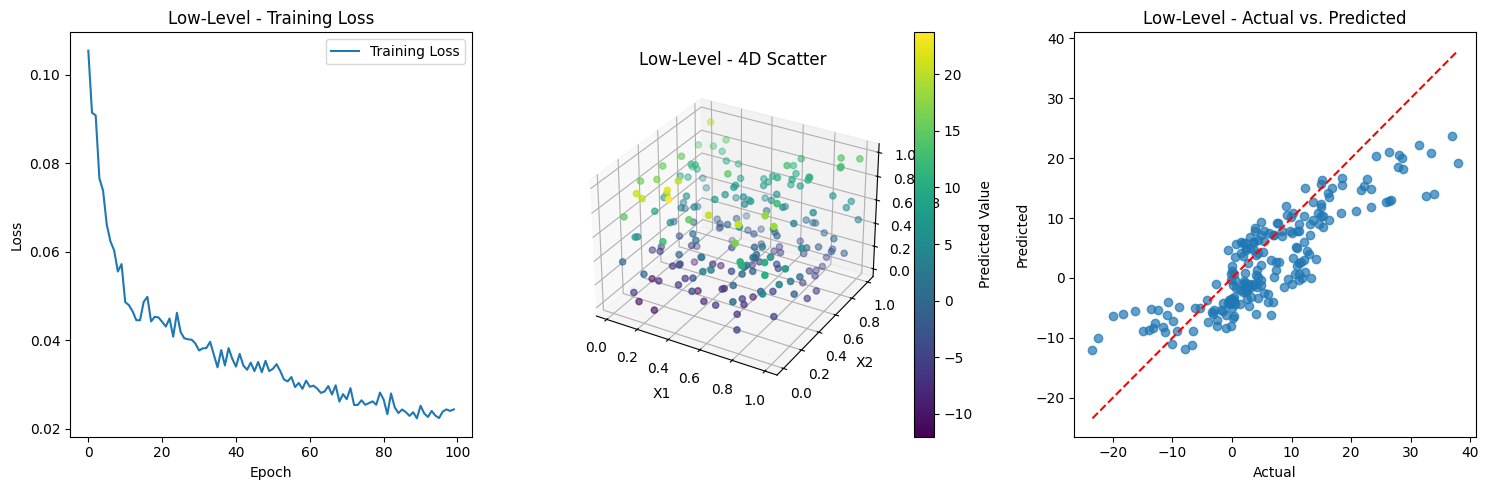


Training Sequential Model:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


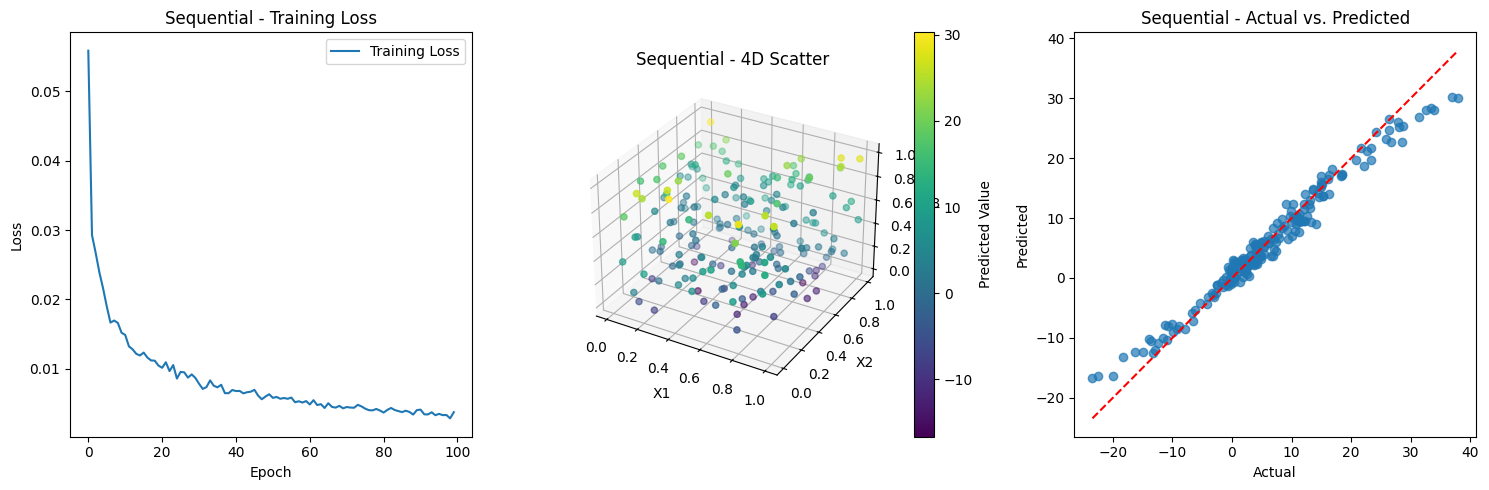


Training Functional Model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


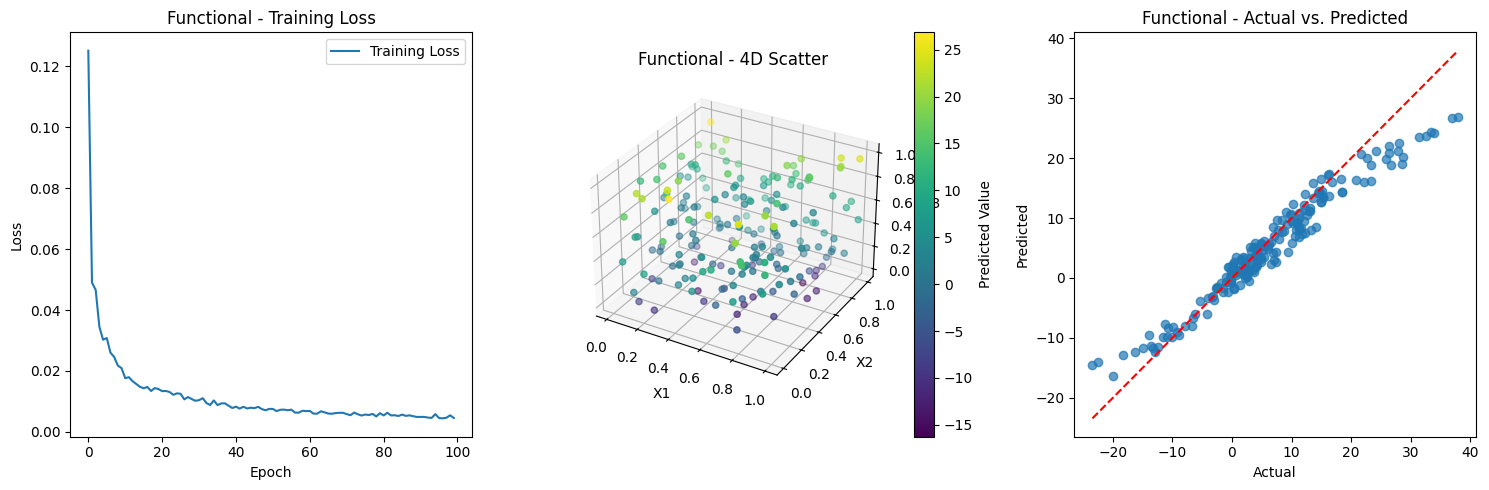


Training Subclass Model:


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


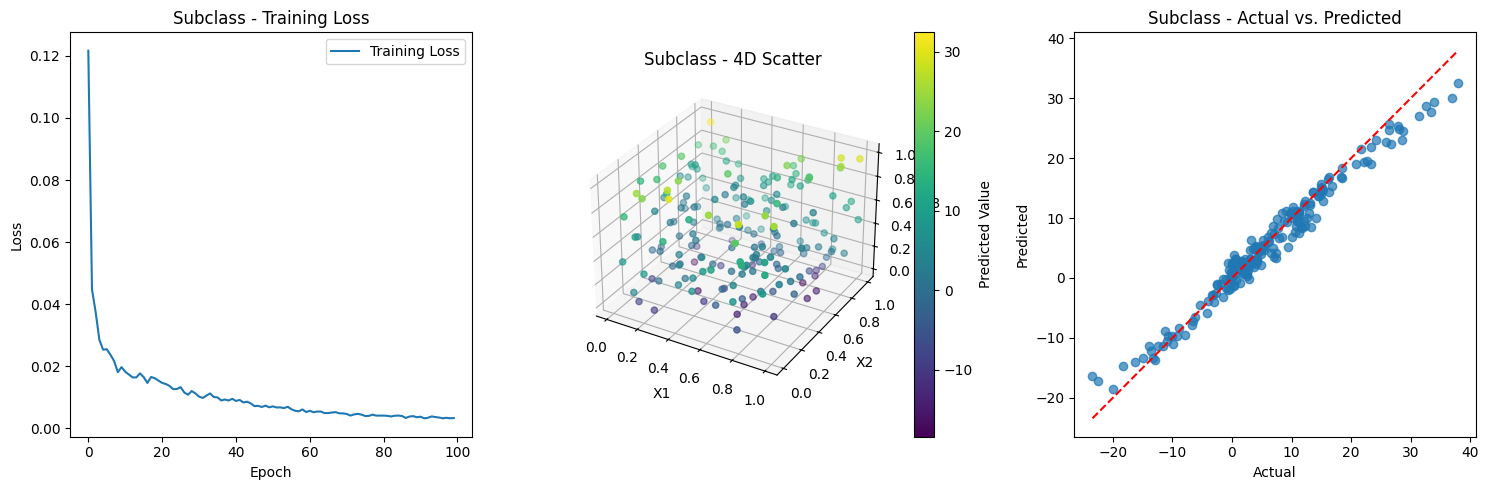

In [9]:
#Running All Variants - Finally, we define a main routine that trains and evaluates each variant.
def run_all_variants():
    variants = ['Low-Level', 'Sequential', 'Functional', 'Subclass']

    for variant in variants:
        print(f"\nTraining {variant} Model:")
        if variant == 'Low-Level':
            low_level_model = LowLevelTFModel(learning_rate=0.001)
            losses = train_low_level_model(low_level_model, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100)
            plot_results(losses, low_level_model, X_test_norm, y_test_norm, variant)
        elif variant == 'Sequential':
            model_seq = create_sequential_model()
            losses, model_seq = train_keras_model(model_seq, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100)
            plot_results(losses, model_seq, X_test_norm, y_test_norm, variant)
        elif variant == 'Functional':
            model_func = create_functional_model()
            losses, model_func = train_keras_model(model_func, X_train_norm, y_train_norm, X_val_norm, y_val_norm, epochs=100)
            plot_results(losses, model_func, X_test_norm, y_test_norm, variant)
        elif variant == 'Subclass':
            model_sub = CustomSubclassModel()
            model_sub.compile(optimizer='adam', loss='mse', metrics=['mae'])
            history = model_sub.fit(X_train_norm, y_train_norm, epochs=100, batch_size=32, validation_data=(X_val_norm, y_val_norm), verbose=0)
            losses = history.history['loss']
            plot_results(losses, model_sub, X_test_norm, y_test_norm, variant)

if __name__ == "__main__":
    run_all_variants()